## Assignment 12

In [1]:
# Import packages
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as ss
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit
from pylab import *
import itertools
from lmfit import  Model

np.random.seed(12345678)  # for reproducibility, set random seed

# Read in data
df = pd.read_csv('../output.csv')

nvox = 64*64*48 # assume number of voxels per bin
df['weighted'] = df['synapses']/df['unmasked']*nvox

xvals = df['cx'].unique()
yvals = df['cy'].unique()
zvals = df['cz'].unique()

# Get rid of the blank edges
bottom = 0;
top = len(xvals);
right = 0;
left = len(yvals);
for z in zvals:
    this_z = df[df['cz']==z]
    
    # X direction
    xhist, bin_edges = np.histogram(this_z['cx'], weights = this_z['unmasked']/(nvox*len(yvals)), bins=len(xvals))
    
    bottom = max(bottom, np.argmax(xhist>0.5))
    top = min(top, len(xvals)-np.argmax(xhist[::-1]>0.5))
    
    # Y direction
    yhist, bin_edges = np.histogram(this_z['cy'], weights = this_z['unmasked']/(nvox*len(xvals)), bins=len(yvals))
    
    right = max(right, np.argmax(yhist>0.5))
    left = min(left, len(yvals)-np.argmax(yhist[::-1]>0.5))

# Copy new dataset without edges
df2 = df.copy()
for z in zvals:
    df2.drop(df2.index[(df2['cx']<xvals[bottom]) | (df2['cx']>=xvals[top])], inplace=True)
    df2.drop(df2.index[(df2['cy']<yvals[right]) | (df2['cy']>=yvals[left])], inplace=True)

xvals = df2['cx'].unique()
yvals = df2['cy'].unique()
zvals = df2['cz'].unique()

df2.head()

cx    cy   cz  unmasked  synapses    weighted
6292  448  1369   55    126357       153  238.063772
6293  448  1369  166    139932       207  290.840237
6294  448  1369  277    150269       194  253.824488
6295  448  1369  388    138071       159  226.410122
6296  448  1369  499    150842       258  336.278119

### Simulate null data for correlation matrix

In [2]:
out = pd.pivot_table(df2, index=('cx','cy'), columns='cz', values='weighted')

mean = df2['weighted'].mean()
std = df2['weighted'].std()

nullout = pd.DataFrame(np.random.normal(mean, std, out.shape), index=out.index, columns=out.columns)
nullout.head()

cz              55          166         277         388         499   \
cx  cy                                                                 
448 1369  282.909329  132.419062  144.755747  128.678597  359.013795   
    1408  136.867059  229.237705  191.484825  294.739551  305.453857   
    1447  238.740409  245.685176  385.094346  321.635951  305.627830   
    1486  325.164232  321.013791  321.121023  339.646971  293.453119   
    1525  298.292937  319.632342  375.645847  211.721892  290.743462   

cz              610         721         832         943         1054  \
cx  cy                                                                 
448 1369  168.591601  277.452126  288.284064  295.514951  309.565319   
    1408  254.711574  321.432070  279.385621  294.856040  291.717984   
    1447  292.217420  153.078339  172.087045  223.989824  168.171703   
    1486  369.907751  269.788765  201.602479  257.147108  304.713402   
    1525  212.433465  360.854079  251.554855  174.391271  239.195915   

cz              1165  
cx  cy                
448 1369  245.443306  
    1408  319.917457  
    1447  337.086460  
    1486  348.893949  
    1525  328.032179

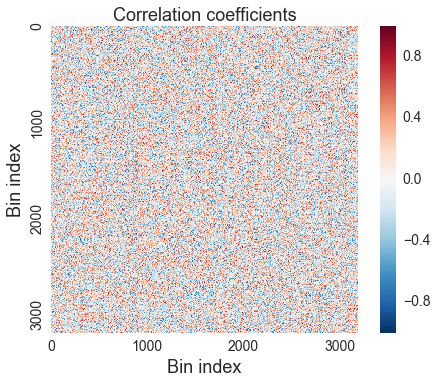

In [3]:
corr = np.corrcoef(nullout)

fs = 18
lfs = 14

plt.figure()
sns.heatmap(corr, square=True, xticklabels=1000, yticklabels=1000)
plt.xlabel('Bin index', fontsize=fs)
plt.ylabel('Bin index', fontsize=fs)
plt.title('Correlation coefficients', fontsize=fs)
plt.tick_params(axis='both', which='major', labelsize=lfs)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=lfs)
plt.show()

In [4]:
diag = corr.diagonal() * np.eye(corr.shape[0])
hollow = corr - diag
d_det = np.linalg.det(diag)
h_det = np.linalg.det(hollow)

print "Ratio of on- and off-diagonal determinants: " + str(d_det / h_det)

Ratio of on- and off-diagonal determinants: 9.50970723979e-26


There are a lot of off-diagonal correlations, despite the samples being independent. This is not a good test for independence (sample size = 11 is too small).

### Linear trends in X, Y, and Z

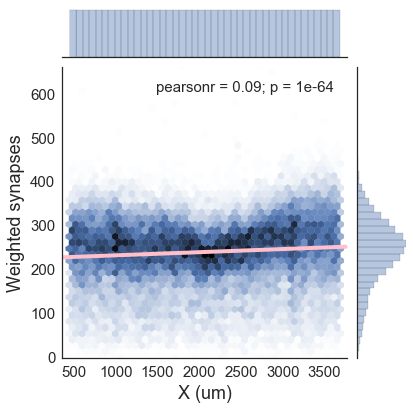

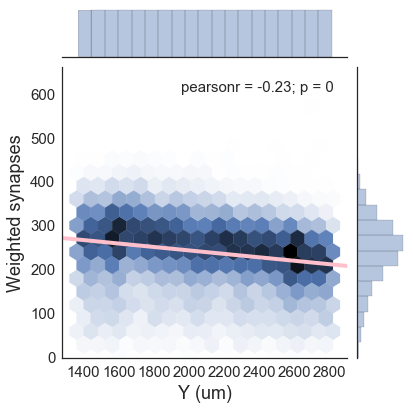

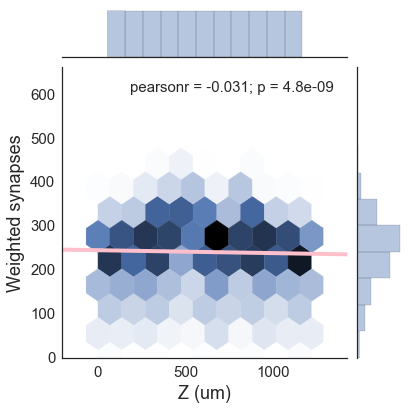

In [5]:
fs = 18

bottom = df2['weighted'].min()
top = df2['weighted'].max()

sns.set_style('white')

avals_list = [xvals, yvals, zvals]
anames = ['cx', 'cy', 'cz']
alabels = ['X (um)', 'Y (um)', 'Z (um)']
ascales = [2, 2, 1]

for avals, aname, alabel, ascale in zip(avals_list, anames, alabels, ascales):
    delta = 2*(avals[1]-avals[0])
    extra = delta / (np.sqrt(3)/2)
    left = np.min(avals) - extra
    right = np.max(avals) + extra

    with sns.plotting_context('notebook', font_scale=1.5):
        g = sns.jointplot(x=aname, y='weighted', data = df2, kind='hex',
                          joint_kws={'gridsize':len(avals)/ascale+1, 'extent':(left, right, bottom, top)},
                          marginal_kws={'bins':len(avals)/ascale})
        g = g.plot_joint(sns.regplot, scatter=False, color='pink', line_kws={'linewidth': 4})
        sns.axlabel(alabel, 'Weighted synapses', fontsize=fs)

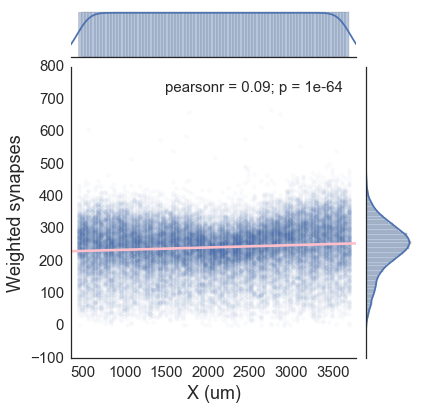

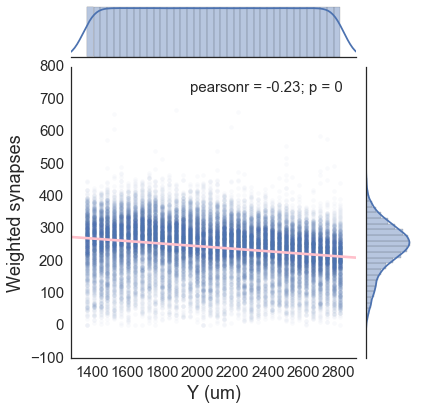

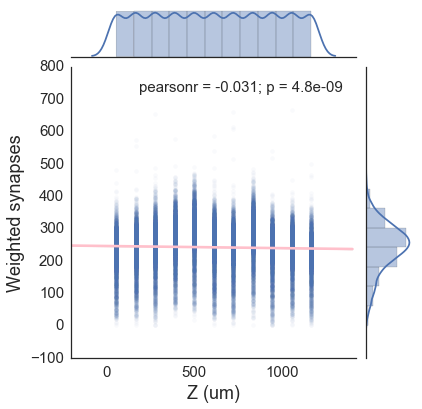

In [6]:
fs = 18

sns.set_style('white')

avals_list = [xvals, yvals, zvals]
anames = ['cx', 'cy', 'cz']
alabels = ['X (um)', 'Y (um)', 'Z (um)']

for avals, aname, alabel in zip(avals_list, anames, alabels):
    delta = 2*(avals[1]-avals[0])
    extra = delta / (np.sqrt(3)/2)
    left = np.min(avals) - extra
    right = np.max(avals) + extra

    with sns.plotting_context('notebook', font_scale=1.5):
        g = sns.jointplot(x=aname, y='weighted', data = df2, kind='reg',
                          scatter_kws={'alpha':0.03}, 
                          line_kws={'color':'pink'}, 
                          marginal_kws={'bins':len(avals)})
        plt.xlim([left, right])
        sns.axlabel(alabel, 'Weighted synapses', fontsize=fs)

### Plotting distribution of clustered groups

In [7]:
from sklearn.cluster import KMeans

optn = 6

est = KMeans(n_clusters = optn)
est.fit(df2['weighted'].reshape(-1,1))
labels = est.labels_
df2['label'] = labels

# Sort groups by means
groups = np.sort(df2['label'].unique())

means = np.array([df2.loc[df2['label']==label,'weighted'].mean() for label in groups])
reindex = np.argsort(means)

new_labels = np.array(labels)

for label in groups:
    new_labels[labels==label] = np.argmax(reindex==label)

df2['label'] = new_labels

means = np.array([df2.loc[df2['label']==label,'weighted'].mean() for label in groups])
print means
counts = np.array([df2.loc[df2['label']==label,'weighted'].count() for label in groups])
print counts

df2.head()

[  81.26724863  157.29704553  215.56281452  262.02986018  309.17641811
  370.52532023]
[2641 4484 8337 9968 7109 2573]


cx    cy   cz  unmasked  synapses    weighted  label
6292  448  1369   55    126357       153  238.063772      2
6293  448  1369  166    139932       207  290.840237      4
6294  448  1369  277    150269       194  253.824488      3
6295  448  1369  388    138071       159  226.410122      2
6296  448  1369  499    150842       258  336.278119      4

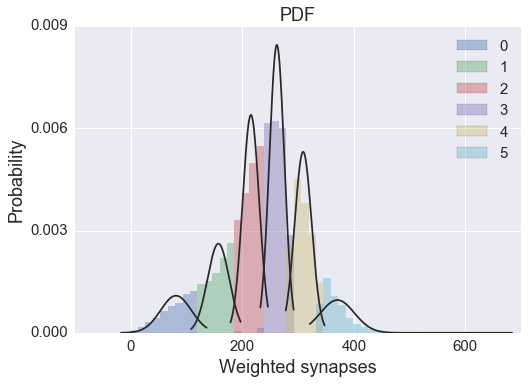

In [8]:
# Plot distributions of our dataset
from scipy.stats import norm

priors = np.array([np.float(count)/np.sum(counts) for count in counts])
# print groups, priors

sns.set_style('darkgrid')

_, bin_edges = np.histogram(df2['weighted'], bins=50)

fs = 18

with sns.plotting_context('notebook', font_scale=1.5):
    plt.figure()
    for label, prior in zip(groups, priors):
        g = sns.distplot(df2[df2['label']==label]['weighted'], bins=bin_edges, kde=False, fit=norm, 
                         label=str(label), hist_kws={'edgecolor': 'none'})

    # weight fit by priors
    for label, prior in zip(groups, priors):
        fit = (plt.gca().lines[label].get_data()[0], prior*plt.gca().lines[label].get_data()[1])
        plt.gca().lines[label].set_data(fit)

    # weight histograms by priors
    scale = -1
    for i in plt.gca().patches:
        lstr = i.get_label()
        if len(lstr)==1:
            label = int(i.get_label())
            scale = priors[label]
        if scale != -1:
            h = i.get_height()
            i.set_height(scale*h)

    plt.gca().set_ylim(0,0.009)
    plt.xlabel('Weighted synapses', fontsize=fs)
    plt.ylabel('Probability', fontsize=fs)
    plt.title('PDF', fontsize=fs)
    plt.legend()
    plt.xticks(np.arange(0,700,200))
    plt.yticks(np.arange(0,0.01,0.003))
    plt.show()

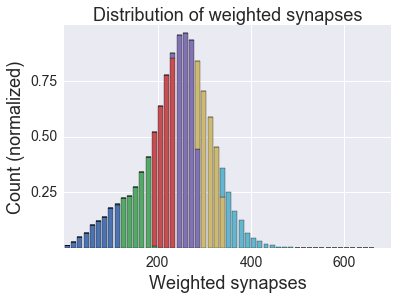

In [9]:
from matplotlib import ticker

fs = 18
tfs = 14

with sns.plotting_context('notebook', font_scale=1.5):
    g = sns.PairGrid(df2, hue='label', vars=['weighted'])
    g = g.map_diag(plt.hist, bins=50)
#     g = g.map_offdiag(plt.scatter)
    plt.gcf().axes[0].set_xlabel('Weighted synapses', fontsize=fs)
    plt.gcf().axes[0].set_ylabel('Count (normalized)', fontsize=fs)
    
    for ax in g.axes.flat:
        ax.xaxis.set_major_locator(ticker.MaxNLocator(4, prune="both"))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(4, prune="both"))

        ax.tick_params(axis='both', which='major', labelsize=tfs)
    
    plt.gcf().set_size_inches(10,6)
    plt.title('Distribution of weighted synapses')
    plt.show()

### Plot X-Y Plane

In [10]:
xval = df2['cx'].unique()
yval = df2['cy'].unique()
zval = df2['cz'].unique()
ncx = []
ncy = []
nval = []

output = [0, 0, 0]
for i in xval:
    for j in yval:    
        val = df2[(df2['cx'] == i) & (df2['cy'] == j)]['weighted'].sum()
        output = vstack((output, [i, j, val]))
dfout = pd.DataFrame(output)
dfout.columns = ['cx', 'cy', 'weighted']
m, n = dfout.shape
dfout = dfout[1:m]
print len(dfout['weighted'])

3192


In [11]:
print dfout['weighted'].unique()[::3]

[ 2753.53758224  2656.40184227  3028.22798933 ...,  2365.08558707
  2583.99299544  2404.55947334]


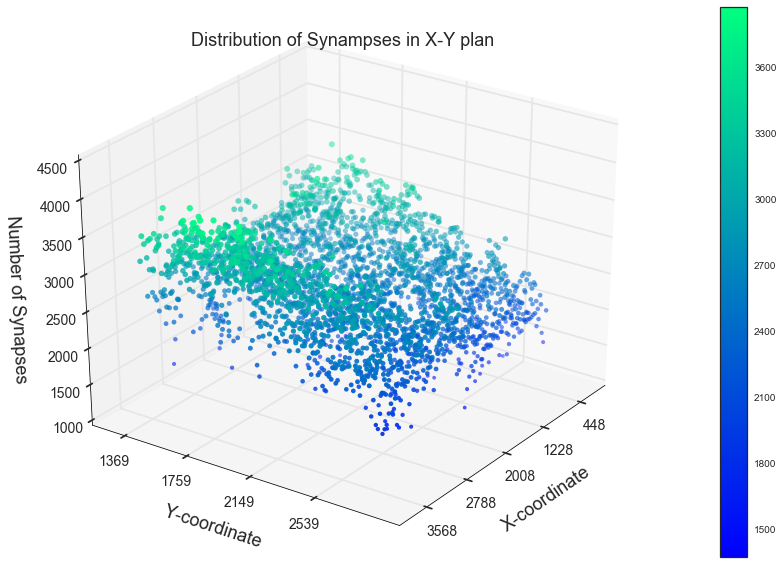

In [12]:
sns.set_style('white')

fs = 18
tfs = 14

ax = plt.figure(figsize = (12, 8)).gca(projection = '3d')
patches = ax.scatter(xs = dfout['cx'], ys = dfout['cy'], zs = dfout['weighted'], 
                     s = dfout['weighted']/100, c = dfout['weighted'], cmap = 'winter',
                     edgecolors = [0,0,0,0])

plt.xticks(dfout['cx'].unique()[::20], fontsize=tfs)
plt.yticks(dfout['cy'].unique()[::10], fontsize=tfs)
#plt.zticks(dfout['weighted'].unique()[0, 1000, 2000, 3000], fontsize=tfs)
#ax.zaxis.set_ticks(dfout['weighted'].unique()[::3])
ax.view_init(azim = 35)
plt.tick_params(axis='both', which='major', labelsize=tfs)
plt.xlabel('X-coordinate', fontsize = fs, labelpad=20)
plt.ylabel('Y-coordinate', fontsize = fs, labelpad=20)
plt.gca().set_zlabel('Number of Synapses', fontsize = fs, labelpad=20)
plt.title('Distribution of Synampses in X-Y plan', fontsize=fs)
plt.colorbar(patches)
plt.tight_layout()
plt.show()


### Curve Fitting with X-Y plane

In [13]:
x_point = np.array(dfout['cx'])
y_point = np.array(dfout['cy'])
synapses = np.array(dfout['weighted'])

def synFun(x, a, b, c):
    return a * x[0] + b * x[1] + c

popt, pcov = curve_fit(synFun, [x_point, y_point], synapses)

print "Estimated coefficients are: %f, %f, %f" % (popt[0], popt[1], popt[2])

Estimated coefficients are: 0.078664, -0.433073, 3399.517072


### Try different function and compute R^2

In [14]:
def test_linear_model(x, a, b, c):
    return a * x[0] + b * x[1] + c 
popt = curve_fit(test_linear_model, [x_point, y_point], synapses)
chi_squared = np.sum(((test_linear_model([x_point, y_point], popt[0][0], popt[0][1], popt[0][2]) - synapses)) ** 2)
reduced_chi_squared = chi_squared / (len(x_point) + len(y_point) - len(popt))
print 'Testing linear_model'
print 'The degrees of freedom for this test is', len(x_point) + len(y_point) - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 

def test_quadratic_model(x, a, b, c):
    return a * x[0] ** 2 + b * x[1] ** 2 + c 
popt = curve_fit(test_quadratic_model, [x_point, y_point], synapses)
chi_squared = np.sum(((test_quadratic_model([x_point, y_point], popt[0][0], popt[0][1], popt[0][2]) - synapses)) ** 2)
reduced_chi_squared = chi_squared / (len(x_point) + len(y_point) - len(popt))
print 'Testing quadratic_model'
print 'The degrees of freedom for this test is', len(x_point) + len(y_point) - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 

def test_cubic_model(x, a, b, c, d, e):
    return a * x[0] ** 3 + b * x[1] ** 3 + c * x[0] + d * x[1] + e 
popt = curve_fit(test_cubic_model, [x_point, y_point], synapses)
chi_squared = np.sum(((test_cubic_model([x_point, y_point], popt[0][0], popt[0][1], popt[0][2], popt[0][3], popt[0][4]) - synapses)) ** 2)
reduced_chi_squared = chi_squared / (len(x_point) + len(y_point) - len(popt))
print 'Testing cubic_model'
print 'The degrees of freedom for this test is', len(x_point) + len(y_point) - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 
 
def test_quartic_model(x, a, b, c, d, e):
    return a * x[0] ** 4 + b * x[1] ** 4 + c * x[0] ** 2 + d * x[1] ** 2 + e   
popt = curve_fit(test_quartic_model, [x_point, y_point], synapses)
chi_squared = np.sum(((test_quartic_model([x_point, y_point], popt[0][0], popt[0][1], popt[0][2], popt[0][3], popt[0][4]) - synapses)) ** 2)
reduced_chi_squared = chi_squared / (len(x_point) + len(y_point) - len(popt))
print 'Testing quartic_model'
print 'The degrees of freedom for this test is', len(x_point) + len(y_point) - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 

def test_logarithmic_model(x, a, b, c):
    return a * np.log(x[0]) + b * np.log(x[1]) + c   
popt = curve_fit(test_logarithmic_model, [x_point, y_point], synapses)
chi_squared = np.sum(((test_logarithmic_model([x_point, y_point], popt[0][0], popt[0][1], popt[0][2]) - synapses)) ** 2)
reduced_chi_squared = chi_squared / (len(x_point) + len(y_point) - len(popt))
print 'Testing logarithmic_model'
print 'The degrees of freedom for this test is', len(x_point) + len(y_point) - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 

def test_powerlaw_model(x, a, b, c, d):
    return a * (x[0] ** b) + c * (x[1] * d)   
popt = curve_fit(test_powerlaw_model, [x_point, y_point], synapses)
chi_squared = np.sum(((test_powerlaw_model([x_point, y_point], popt[0][0], popt[0][1], popt[0][2], popt[0][3]) - synapses)) ** 2)
reduced_chi_squared = chi_squared / (len(x_point) + len(y_point) - len(popt))

print 'Testing powerlaw_model'
print 'The degrees of freedom for this test is', len(x_point) + len(y_point) - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 

def test_interaction_model(x, a, b, c, d):
    return a * x[0] + b * x[1] + c * x[0] * x[1] + d    

popt = curve_fit(test_interaction_model, [x_point, y_point], synapses)
chi_squared = np.sum(((test_interaction_model([x_point, y_point], popt[0][0], popt[0][1], popt[0][2], popt[0][3]) - synapses)) ** 2)
reduced_chi_squared = chi_squared / (len(x_point) + len(y_point) - len(popt))
print 'Testing interaction_model'
print 'The degrees of freedom for this test is', len(x_point) + len(y_point) - len(popt)
print 'The chi squared value is: ', ("%.2f" % chi_squared)
print 'The reduced chi squared value is: ', ("%.2f" % reduced_chi_squared)
print 


Testing linear_model
The degrees of freedom for this test is 6382
The chi squared value is:  369310706.41
The reduced chi squared value is:  57867.55

Testing quadratic_model
The degrees of freedom for this test is 6382
The chi squared value is:  354842768.47
The reduced chi squared value is:  55600.56

Testing cubic_model
The degrees of freedom for this test is 6382
The chi squared value is:  333490887.78
The reduced chi squared value is:  52254.92

Testing quartic_model
The degrees of freedom for this test is 6382
The chi squared value is:  337008269.64
The reduced chi squared value is:  52806.06

Testing logarithmic_model
The degrees of freedom for this test is 6382
The chi squared value is:  386741527.58
The reduced chi squared value is:  60598.80

Testing powerlaw_model
The degrees of freedom for this test is 6382
The chi squared value is:  377808966.68
The reduced chi squared value is:  59199.15

Testing interaction_model
The degrees of freedom for this test is 6382
The chi squar

### Compute Test Statistics for each Model 

In [15]:
popt = curve_fit(test_linear_model, [x_point, y_point], synapses)
model_1 = Model(test_linear_model)
result_1 = model_1.fit(synapses, x = [x_point, y_point], a = popt[0][0], b = popt[0][1], c = popt[0][2])

popt = curve_fit(test_quadratic_model, [x_point, y_point], synapses)
model_2 = Model(test_quadratic_model)
result_2 = model_2.fit(synapses, x = [x_point, y_point], a = popt[0][0], b = popt[0][1], c = popt[0][2])

popt = curve_fit(test_cubic_model, [x_point, y_point], synapses)
model_3 = Model(test_cubic_model)
result_3 = model_3.fit(synapses, x = [x_point, y_point], a = popt[0][0], b = popt[0][1], c = popt[0][2], d = popt[0][3], e = popt[0][4])

popt = curve_fit(test_quartic_model, [x_point, y_point], synapses)
model_4 = Model(test_quartic_model)
result_4 = model_4.fit(synapses, x = [x_point, y_point], a = popt[0][0], b = popt[0][1], c = popt[0][2], d = popt[0][3], e = popt[0][4])

popt = curve_fit(test_logarithmic_model, [x_point, y_point], synapses)
model_5 = Model(test_logarithmic_model)
result_5 = model_5.fit(synapses, x = [x_point, y_point], a = popt[0][0], b = popt[0][1], c = popt[0][2])

popt = curve_fit(test_powerlaw_model, [x_point, y_point], synapses)
model_6 = Model(test_powerlaw_model)
result_6 = model_6.fit(synapses, x = [x_point, y_point], a = popt[0][0], b = popt[0][1], c = popt[0][2], d = popt[0][3])

popt = curve_fit(test_interaction_model, [x_point, y_point], synapses)
model_7 = Model(test_interaction_model)
result_7 = model_7.fit(synapses, x = [x_point, y_point], a = popt[0][0], b = popt[0][1], c = popt[0][2], d = popt[0][3])



 - Adding parameter "a"
 - Adding parameter "b"
 - Adding parameter "c"
 - Adding parameter "a"
 - Adding parameter "b"
 - Adding parameter "c"
 - Adding parameter "a"
 - Adding parameter "b"
 - Adding parameter "c"
 - Adding parameter "d"
 - Adding parameter "e"
 - Adding parameter "a"
 - Adding parameter "b"
 - Adding parameter "c"
 - Adding parameter "d"
 - Adding parameter "e"
 - Adding parameter "a"
 - Adding parameter "b"
 - Adding parameter "c"
 - Adding parameter "a"
 - Adding parameter "b"
 - Adding parameter "c"
 - Adding parameter "d"
 - Adding parameter "a"
 - Adding parameter "b"
 - Adding parameter "c"
 - Adding parameter "d"


### Print out the results of test statistics and model selection

In [16]:
print result_1.fit_report()
print result_2.fit_report()
print result_3.fit_report()
print result_4.fit_report()
print result_5.fit_report()
print result_6.fit_report()
print result_7.fit_report()
print "According to AIC, Cubic Model is so far the best fitted model among 7 candidates."

[[Model]]
    Model(test_linear_model)
[[Fit Statistics]]
    # function evals   = 6
    # data points      = 3192
    # variables        = 3
    chi-square         = 369310706.413
    reduced chi-square = 115807.685
[[Variables]]
    a:   0.07866415 +/- 0.006369 (8.10%) (init= 0.07866415)
    b:  -0.43307322 +/- 0.014084 (3.25%) (init=-0.4330732)
    c:   3399.51712 +/- 32.80890 (0.97%) (init= 3399.517)
[[Correlations]] (unreported correlations are <  0.100)
    C(b, c)                      = -0.897 
    C(a, c)                      = -0.401 

[[Model]]
    Model(test_quadratic_model)
[[Fit Statistics]]
    # function evals   = 6
    # data points      = 3192
    # variables        = 3
    chi-square         = 354842768.469
    reduced chi-square = 111270.859
[[Variables]]
    a:   2.2450e-05 +/- 1.48e-06 (6.59%) (init= 2.245049e-05)
    b:  -0.00010618 +/- 3.29e-06 (3.10%) (init=-0.0001061814)
    c:   3024.24155 +/- 17.81681 (0.59%) (init= 3024.242)
[[Correlations]] (unreported corr

### Plot the fitted and actual number of synapses distribution

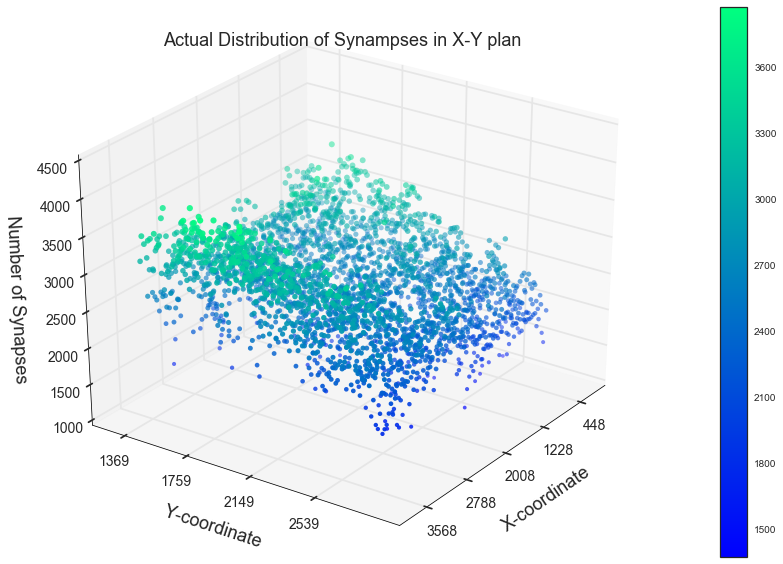

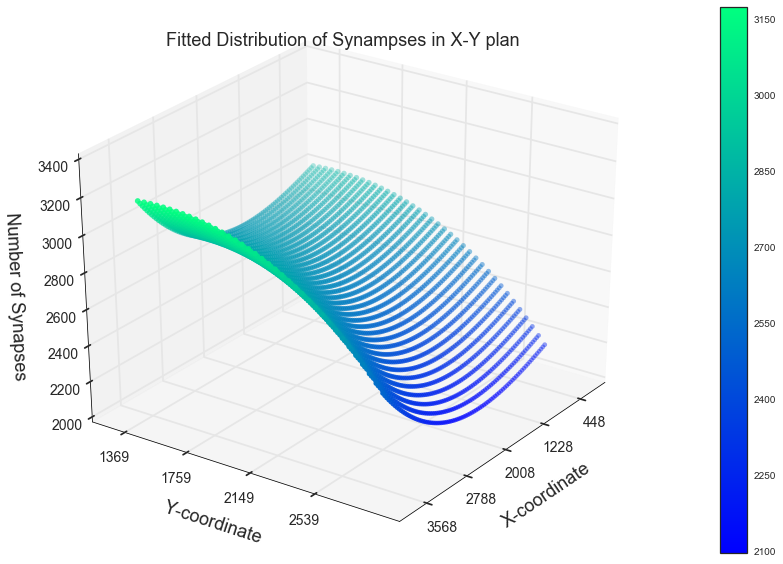

In [17]:
popt = curve_fit(test_cubic_model, [x_point, y_point], synapses)

def test_cubic_model(x, a, b, c, d, e):
    return a * x[0] ** 3 + b * x[1] ** 3 + c * x[0] + d * x[1] + e 

pred = test_cubic_model([x_point, y_point],popt[0][0], popt[0][1], popt[0][2], popt[0][3], popt[0][4])

series = [dfout['weighted'], pred]
stri = ["Actual Distribution of Synampses in X-Y plan", "Fitted Distribution of Synampses in X-Y plan"]

for i, k in zip(series, stri):
    sns.set_style('white')

    fs = 18
    tfs = 14

    ax = plt.figure(figsize = (12, 8)).gca(projection = '3d')
    patches = ax.scatter(xs = dfout['cx'], ys = dfout['cy'], zs = i, 
                         s = i/100, c = i, cmap = 'winter',
                         edgecolors = [0,0,0,0])

    plt.xticks(dfout['cx'].unique()[::20], fontsize=tfs)
    plt.yticks(dfout['cy'].unique()[::10], fontsize=tfs)
    #plt.zticks(dfout['weighted'].unique()[0, 1000, 2000, 3000], fontsize=tfs)
    #ax.zaxis.set_ticks(dfout['weighted'].unique()[::3])
    ax.view_init(azim = 35)
    plt.tick_params(axis='both', which='major', labelsize=tfs)
    plt.xlabel('X-coordinate', fontsize = fs, labelpad=20)
    plt.ylabel('Y-coordinate', fontsize = fs, labelpad=20)
    plt.gca().set_zlabel('Number of Synapses', fontsize = fs, labelpad=20)
    plt.title(k, fontsize=fs)
    plt.colorbar(patches)
    plt.tight_layout()
    plt.show()



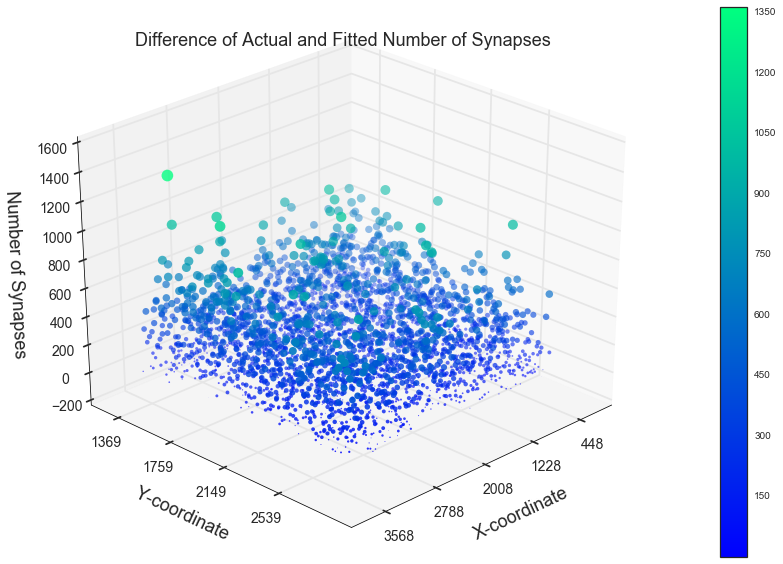

In [18]:
residual = abs(pred - dfout['weighted'])

sns.set_style('white')

fs = 18
tfs = 14

ax = plt.figure(figsize = (12, 8)).gca(projection = '3d')
patches = ax.scatter(xs = dfout['cx'], ys = dfout['cy'], zs = residual, 
                     s = residual/10, c = residual, cmap = 'winter',
                     edgecolors = [0,0,0,0])

plt.xticks(dfout['cx'].unique()[::20], fontsize=tfs)
plt.yticks(dfout['cy'].unique()[::10], fontsize=tfs)
#plt.zticks(dfout['weighted'].unique()[0, 1000, 2000, 3000], fontsize=tfs)
#ax.zaxis.set_ticks(dfout['weighted'].unique()[::3])
ax.view_init(azim = 45)
plt.tick_params(axis='both', which='major', labelsize=tfs)
plt.xlabel('X-coordinate', fontsize = fs, labelpad=20)
plt.ylabel('Y-coordinate', fontsize = fs, labelpad=20)
plt.gca().set_zlabel('Number of Synapses', fontsize = fs, labelpad=20)
plt.title("Difference of Actual and Fitted Number of Synapses", fontsize=fs)
plt.colorbar(patches)
plt.tight_layout()
plt.show()

### Seperately display clusters distribution

In [19]:
from sklearn.cluster import KMeans
optn = 6
est = KMeans(n_clusters = optn)
est.fit(df2['weighted'].reshape(-1,1))
labels = est.labels_
df2['label'] = labels

# Sort groups by means
groups = np.sort(df2['label'].unique())

means = np.array([df2.loc[df2['label']==label,'weighted'].mean() for label in groups])
print means
reindex = np.argsort(means)
print reindex

new_labels = np.array(labels)

for label in groups:
    new_labels[labels==label] = np.argmax(reindex==label)

df2['label'] = new_labels

means = np.array([df2.loc[df2['label']==label,'weighted'].mean() for label in groups])

df2.head()

[ 155.17545993  259.95359669  307.1369433   213.45950598   80.20085416
  368.73636454]
[4 0 3 1 2 5]


cx    cy   cz  unmasked  synapses    weighted  label
6292  448  1369   55    126357       153  238.063772      3
6293  448  1369  166    139932       207  290.840237      4
6294  448  1369  277    150269       194  253.824488      3
6295  448  1369  388    138071       159  226.410122      2
6296  448  1369  499    150842       258  336.278119      4

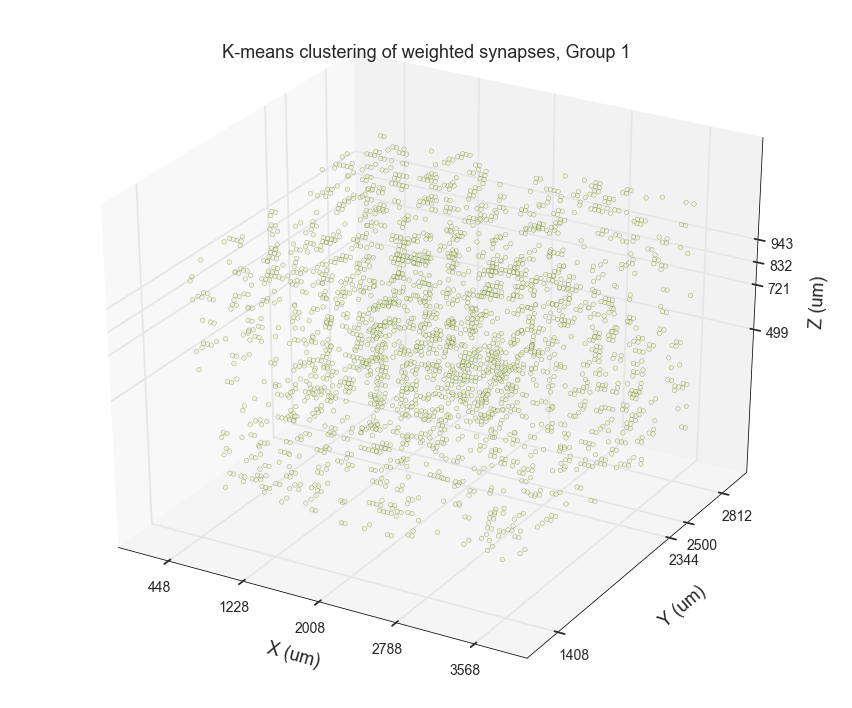

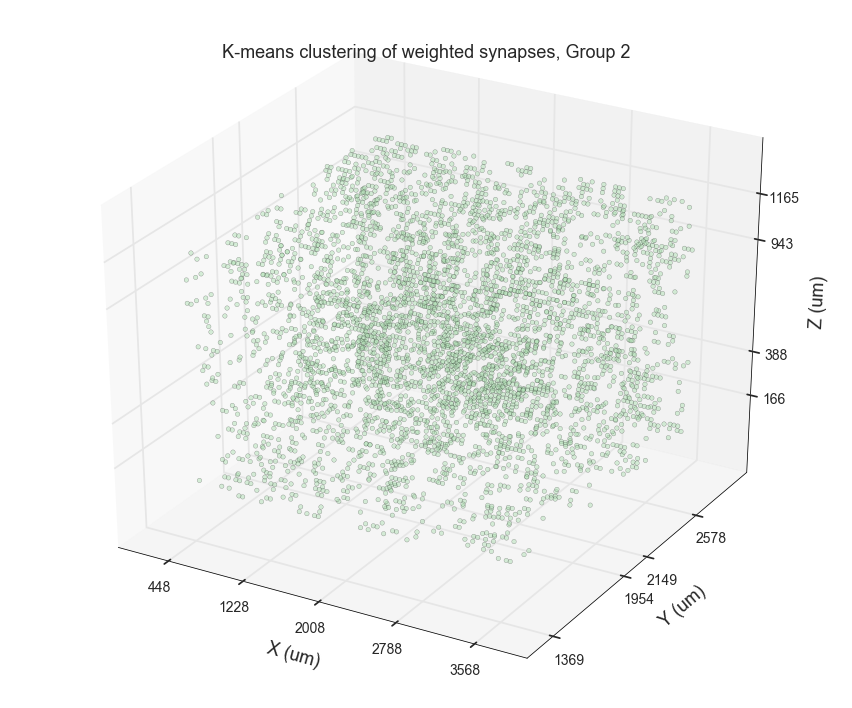

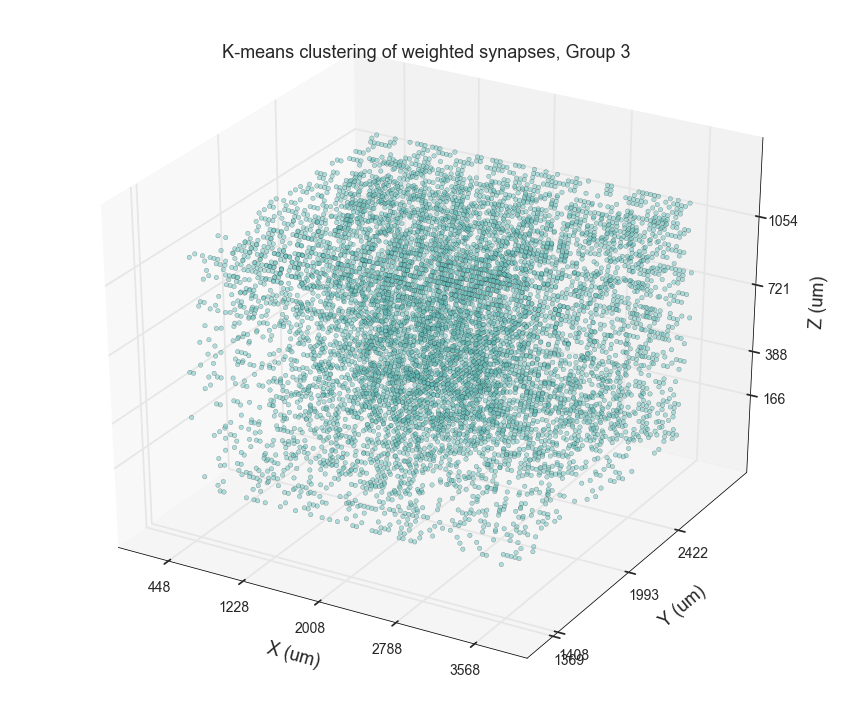

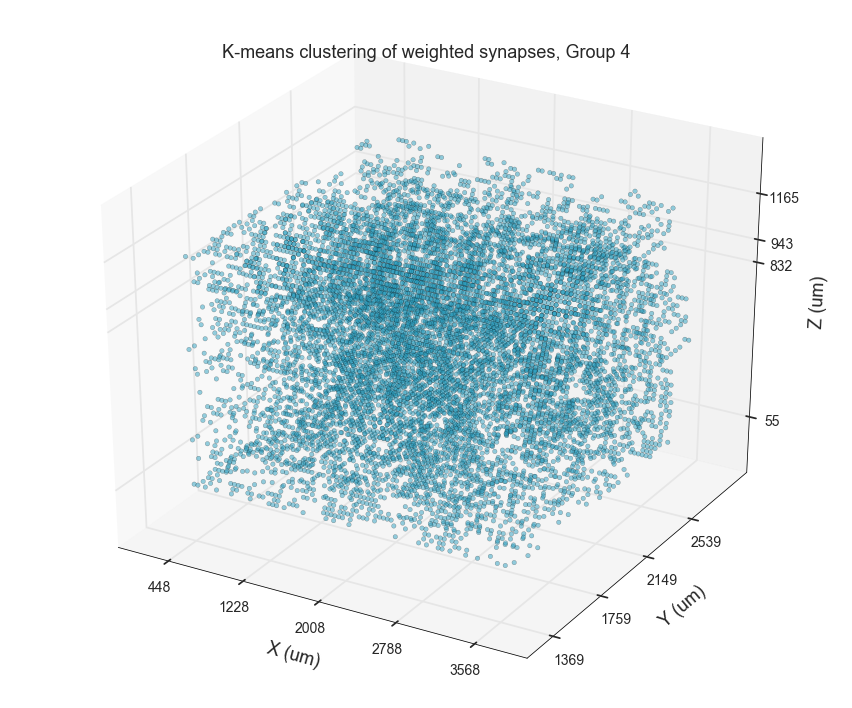

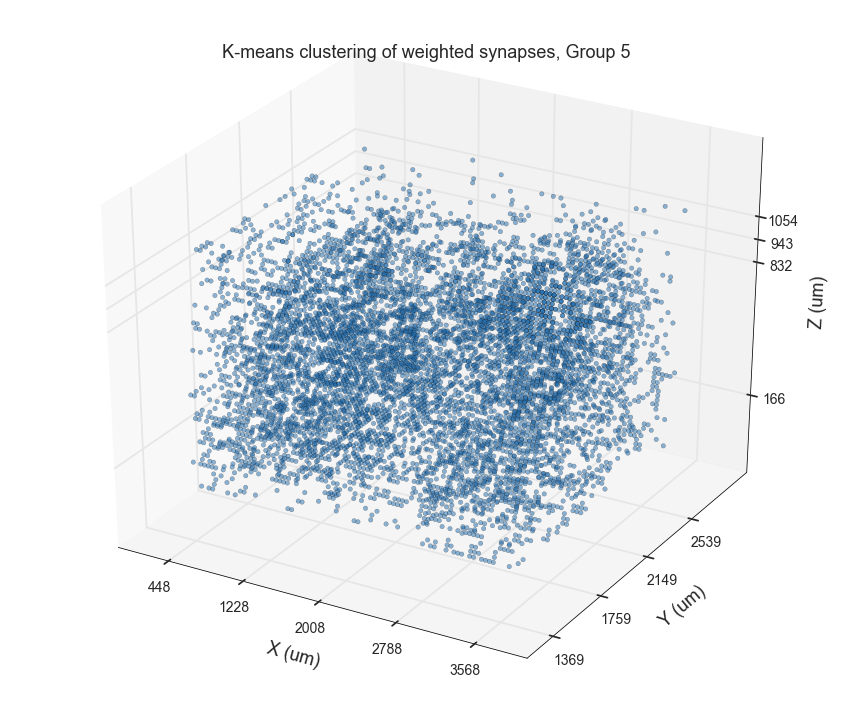

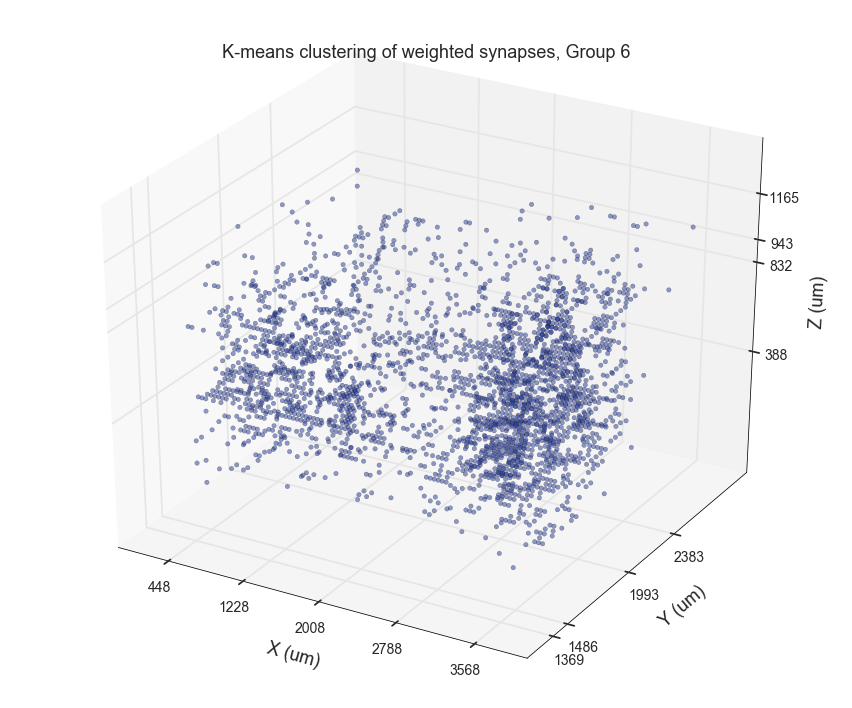

In [20]:
for i in range(0, 6):
    df3 = df2[df2['label'] == i]
    
    sns.set_style('white')

    fs = 18
    tfs = 14

    wt_max = 400 
    wt_min = df3['weighted'].min()
    cmap = np.array(sns.color_palette('YlGnBu'))

    colors = [np.append(cmap[i], np.min((1,(wt - wt_min)/(wt_max - wt_min)))) for wt in df3['weighted']]

    ax = plt.figure(figsize = (12, 10)).gca(projection = '3d')
    patches = ax.scatter(xs = df3['cx'], ys = df3['cy'], zs = df3['cz'], 
                         s = 20, c = colors, edgecolors = [0,0,0,0], alpha = 0.5)
    plt.xticks(df3['cx'].unique()[::20], fontsize = tfs)
    plt.yticks(df3['cy'].unique()[::10], fontsize = tfs)
    ax.zaxis.set_ticks(df3['cz'].unique()[::3])
    plt.tick_params(axis = 'both', which='major', labelsize = tfs)
    plt.xlabel('X (um)', fontsize = fs, labelpad = 20)
    plt.ylabel('Y (um)', fontsize = fs, labelpad = 20)
    plt.gca().set_zlabel('Z (um)', fontsize = fs, labelpad = 20)
    plt.title('K-means clustering of weighted synapses, Group %d' % (i+1), fontsize = fs)
    plt.tight_layout()
    plt.show()